In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import cmcrameri
import re
import matplotlib

In [3]:
paths = [
    "../results/optimal_hp_multiple_seeds/ks/fno/20240911_142632_ks_fno_sr_dropout/",
    "../results/optimal_hp_multiple_seeds/ks/fno/20240911_142834_ks_fno_dropout/",
    "../results/optimal_hp_multiple_seeds/ks/fno/20250219_173318_ks_fno_sr_dropout_finetuning/",
]

sr_dropout_results = pd.read_csv(paths[0] + "test.csv", index_col=0)
dropout_results = pd.read_csv(paths[1] + "test.csv", index_col=0)
fine_tuning_results = pd.read_csv(paths[2] + "test.csv", index_col=0)

results = [sr_dropout_results, dropout_results, fine_tuning_results]
names = ["SR Dropout", "Deterministic", "Fine Tuning"]

# Create table

In [4]:
metrics = ['t_training','MSETest','EnergyScoreTest', 'CRPSTest', 'Gaussian NLLTest', 'CoverageTest',
    'IntervalWidthTest']

In [5]:
index = pd.MultiIndex.from_product([names, ["Mean", "Std"]], names=["Method", "Statistic"])
results_df = pd.DataFrame(columns = metrics, index = index)
results_df.insert(1, "Epochs",0)

In [6]:
for i, res in enumerate(results):
    results_df.loc[(names[i], "Mean"), metrics] = res.loc[metrics].astype("float").mean(axis = 1)
    results_df.loc[(names[i], "Std"), metrics] = res.loc[metrics].astype("float").std(axis = 1)
    results_df.loc[names[i], "t_training"] = res.loc["t_training"].astype("float")[0]

/tmp/ipykernel_1587064/1391808970.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.loc[names[i], "t_training"] = res.loc["t_training"].astype("float")[0]
/tmp/ipykernel_1587064/1391808970.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.loc[names[i], "t_training"] = res.loc["t_training"].astype("float")[0]
/tmp/ipykernel_1587064/1391808970.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.loc

In [7]:
# Read epochs from log file
keepline = ": Early stopping"
for i,path in enumerate(paths):
    epoch_dict = []

    with open(
        path + "experiment.log"
    ) as f:
        for line in f:
            if keepline in line:
                epoch_dict.append(line)

    epochs = np.array([[float(s) for s in re.findall(r'\b\d+\b', e)][0] for e in epoch_dict])
    results_df.loc[(names[i], "Mean"), "Epochs"] = np.mean(epochs)
    results_df.loc[(names[i], "Std"), "Epochs"] = np.std(epochs)

# Manually adjust training time
t_dropout = results_df.loc[("Deterministic", "Mean"), "t_training"] / 98
t_sr_dropout = results_df.loc[("SR Dropout", "Mean"), "t_training"] / 142
t_fine_tuning= results_df.loc[("Fine Tuning", "Mean"), "t_training"] / 38

for i,t in enumerate([t_sr_dropout, t_dropout, t_fine_tuning]):
    results_df.loc[(names[i], "Mean"), "t_training"] = t * results_df.loc[(names[i], "Mean"), "Epochs"]
    results_df.loc[(names[i], "Std"), "t_training"] = t * results_df.loc[(names[i], "Std"), "Epochs"]

#Round table
results_df = results_df.astype("float").round(4).transpose()

/tmp/ipykernel_1587064/2550698556.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '150.77777777777777' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results_df.loc[(names[i], "Mean"), "Epochs"] = np.mean(epochs)


In [8]:
results_df

Method            SR Dropout           Deterministic           Fine Tuning  \
Statistic               Mean       Std          Mean       Std        Mean   
t_training         6633.3335  843.6418     4090.9920  356.4120   1971.7101   
Epochs              150.7778   19.1762      112.3333    9.7866     46.3333   
MSETest               0.8793    0.0072        0.8635    0.0048      0.8702   
EnergyScoreTest       0.6195    0.0049        0.7541    0.0049      0.6130   
CRPSTest              0.5496    0.0097        0.5974    0.0058      0.5343   
Gaussian NLLTest      3.0389    0.5872      107.1038   22.9412      6.0401   
CoverageTest          0.7640    0.0191        0.3600    0.0082      0.7950   
IntervalWidthTest     3.0852    0.0422        0.6046    0.0164      3.1327   

Method                       
Statistic               Std  
t_training         574.0969  
Epochs              13.4907  
MSETest              0.0046  
EnergyScoreTest      0.0033  
CRPSTest             0.0080  
Gaussian NLLTest     1.9573  
CoverageTest         0.0154  
IntervalWidthTest    0.0288

In [9]:
results_df.index

Index(['t_training', 'Epochs', 'MSETest', 'EnergyScoreTest', 'CRPSTest',
       'Gaussian NLLTest', 'CoverageTest', 'IntervalWidthTest'],
      dtype='object')

In [10]:
# Create latex table
formatted_df = pd.DataFrame()
metrics = results_df.index # Extract only test metrics

# Create a new DataFrame with the method as the index and metrics as columns
for metric in metrics:
    formatted_df[metric] = [
        f"\\makecell{{{results_df.loc[metric, method].values[0]:.4f} \\\\ ($\\pm$ {results_df.loc[metric, method].values[1]:.4f})}}"
        for method in names
    ]
formatted_df.index = names
latex_table = formatted_df.transpose().to_latex(escape=False)
print(latex_table)

\begin{tabular}{llll}
\toprule
 & SR Dropout & Deterministic & Fine Tuning \\
\midrule
t_training & \makecell{6633.3335 \\ ($\pm$ 843.6418)} & \makecell{4090.9920 \\ ($\pm$ 356.4120)} & \makecell{1971.7101 \\ ($\pm$ 574.0969)} \\
Epochs & \makecell{150.7778 \\ ($\pm$ 19.1762)} & \makecell{112.3333 \\ ($\pm$ 9.7866)} & \makecell{46.3333 \\ ($\pm$ 13.4907)} \\
MSETest & \makecell{0.8793 \\ ($\pm$ 0.0072)} & \makecell{0.8635 \\ ($\pm$ 0.0048)} & \makecell{0.8702 \\ ($\pm$ 0.0046)} \\
EnergyScoreTest & \makecell{0.6195 \\ ($\pm$ 0.0049)} & \makecell{0.7541 \\ ($\pm$ 0.0049)} & \makecell{0.6130 \\ ($\pm$ 0.0033)} \\
CRPSTest & \makecell{0.5496 \\ ($\pm$ 0.0097)} & \makecell{0.5974 \\ ($\pm$ 0.0058)} & \makecell{0.5343 \\ ($\pm$ 0.0080)} \\
Gaussian NLLTest & \makecell{3.0389 \\ ($\pm$ 0.5872)} & \makecell{107.1038 \\ ($\pm$ 22.9412)} & \makecell{6.0401 \\ ($\pm$ 1.9573)} \\
CoverageTest & \makecell{0.7640 \\ ($\pm$ 0.0191)} & \makecell{0.3600 \\ ($\pm$ 0.0082)} & \makecell{0.7950 \\ ($\pm$ 

# Create plots

In [11]:
def get_losses(paths, idx):
    # Read epochs from first run of log file
    keepline = "Training loss:"
    stopline = ": Early stopping"
    # for i,path in enumerate(paths):
    #     epoch_dict = []
    lines = []
    with open(
        paths[idx] + "experiment.log"
    ) as f:
        for line in f:
            if keepline in line:
                lines.append(line)
            if stopline in line:
                break

    train_loss = []
    val_loss = []
    for l in lines:
        train, val = [float(s) for s in re.findall(r"\d+\.\d+", l)][0:2]
        train_loss.append(train)
        val_loss.append(val)
    return train_loss, val_loss

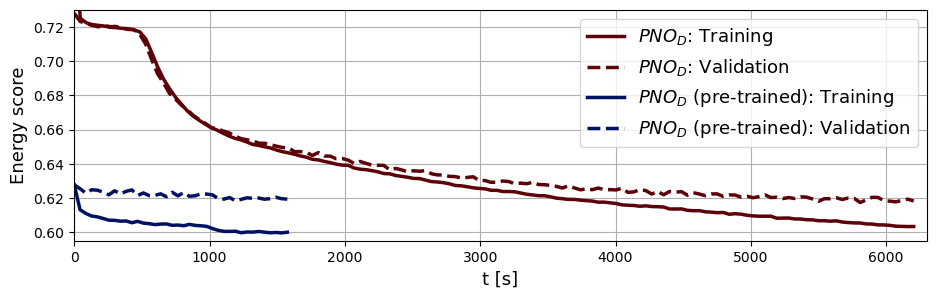

In [29]:
cmap = matplotlib.colormaps.get_cmap('cmc.vik')

dropout_color = cmap(0.99)
fine_tuning_color = cmap(0)
legendsize = 13
labelsize = 13
lw = 2.5

fig, axs = plt.subplots(figsize = (11,3))
# SR Dropout
train_loss, val_loss = get_losses(paths, 0)
n_epochs = len(train_loss)
x = np.arange(0,n_epochs)*t_sr_dropout
axs.plot(x, train_loss,  "-", color = dropout_color, label = r"$PNO_D$: Training", lw = lw)
axs.plot(x, val_loss, "--", color = dropout_color,  label = r"$PNO_D$: Validation", lw = lw)


# Fine tuning
train_loss, val_loss = get_losses(paths, 2)
n_epochs = len(train_loss)
x = np.arange(0,n_epochs)*t_fine_tuning
axs.plot(x, train_loss, "-", color = fine_tuning_color, label = r"$PNO_D$ (pre-trained): Training", lw = lw)
axs.plot(x, val_loss, "--", color = fine_tuning_color, label = r"$PNO_D$ (pre-trained): Validation", lw = lw)

axs.set_xlabel("t [s]", size = labelsize)
axs.set_ylabel("Energy score", size = labelsize)
axs.set_ylim([0.595,0.73])
axs.set_xlim([0,6300])
axs.legend(fontsize = legendsize, loc = "best")
plt.grid(True)

plt.savefig("plots/plots/finetuning.pdf", dpi = 300, bbox_inches = "tight")

In [ ]:
t_epoch

3568.996